# Reverse-Engineering - Data Gathering: Zeeguu Web

This notebook has been developed utilizing [this colab notebook, by Mircea Lungu](https://colab.research.google.com/drive/1oe_TV7936Zmmzbbgq8rzqFpxYPX7SQHP#scrollTo=Ssb7D6FsoD6F) as inspiration and a buuuuunch of chatgpt code

## Setup

### Import dependenies
- Apply (git-) functionality environment
- Connect to git repo
- Map entities in a plot

In [2]:
import sys
sys.version
!{sys.executable} -m pip install gitpython
!{sys.executable} -m pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.2 MB/s eta 0:00:00


### Clone from github repo

In [2]:
import os
from git import Repo

cwd = os.getcwd()

SRC="/content/zeeguu-web/"
GIT_REPO="https://github.com/zeeguu/web.git"

# If the file exists, it means we've already downloaded
if not os.path.exists(SRC):
  Repo.clone_from(GIT_REPO, SRC)

### Helper functions & variables

In [3]:
# helper function to get a file path w/o having to always provide the src prefix
def file_path(file_name):
    return SRC+file_name

In [4]:
ROOT=file_path("")

### Distinct File types

In [37]:
from pathlib import Path

def get_distinct_filetypes(path):
    """
    Walk `path` recursively and collect all distinct file extensions.
    - If a file has multiple suffixes (e.g. foo.sc.js), it records the combined
      suffix '.sc.js'.
    - If there's only a single suffix, it records that (e.g. '.js').
    - If there is no suffix, it records ''.
    Returns a sorted list of unique extensions.
    """
    exts = set()
    for root, _, files in os.walk(path):
        for fname in files:
          p = Path(fname)
          suffixes = p.suffixes  # list of all suffixes, each with leading dot
          if not suffixes:
              exts.add('')
          elif len(suffixes) == 1:
              exts.add(suffixes[0])
          else:
              # join all suffixes to capture multi-part extensions
              exts.add(''.join(suffixes))
    return sorted(
        exts,
        key=lambda ext: (ext.rsplit('.', 1)[-1], ext)
    )

# Example usage:
filetypes = get_distinct_filetypes(ROOT)
print("Distinct filetypes in", ROOT, ":\n", filetypes)

Distinct filetypes in /content/zeeguu-web/ :
 ['', '.config', '.css', '.development.default', '.production.default', '.eot', '.gif', '.html', '.ico', '.idx', '.jpg', '.js', '.sc.js', '.json', '.md', '.pack', '.com.png', '.dk.png', '.fr.png', '.it.png', '.panorama.it.png', '.png', '.ro.png', '.sample', '.sh', '.svg', '.ttf', '.txt', '.woff', '.woff2']


### Metrics

In [7]:
from pathlib import Path
import pandas as pd
from IPython.display import display

def get_metrics(path, extensions):
    """
    Walk `path` recursively and compute, for each ext in `extensions`:
      - file_count, total_loc, total_imports.
    Then the 'ALL' row is the sum of those buckets only.

    Returns a DataFrame with columns:
      ['extension', 'file_count', 'total_loc', 'total_imports']
    """
    # Drop any empty-string extensions if present
    extensions = [ext for ext in extensions if ext]

    # Initialize per-extension accumulators
    per_ext = {ext: {'count': 0, 'loc': 0, 'imports': 0} for ext in extensions}

    # Traverse and bucket
    for root, _, files in os.walk(path):
        for fname in files:
            full = os.path.join(root, fname)

            # Determine which bucket(s) this file belongs to
            matching = [ext for ext in extensions if fname.endswith(ext)]
            if not matching:
                continue

            # Read LOC and import count
            try:
                with open(full, 'r', encoding='utf-8', errors='ignore') as fp:
                    lines = fp.readlines()
                loc = len(lines)
                imp = sum(1 for L in lines if L.strip().startswith("import "))
            except Exception:
                loc = imp = 0

            # Update each matched bucket
            for ext in matching:
                per_ext[ext]['count']   += 1
                per_ext[ext]['loc']     += loc
                per_ext[ext]['imports'] += imp

    # Build rows for each extension
    rows = []
    for ext, m in per_ext.items():
        rows.append({
            'extension': ext,
            'file_count': m['count'],
            'total_loc':  m['loc'],
            'total_imports': m['imports']
        })

    # Aggregate for ALL
    all_count   = sum(m['count']   for m in per_ext.values())
    all_loc     = sum(m['loc']     for m in per_ext.values())
    all_imports = sum(m['imports'] for m in per_ext.values())

    # Prepend the ALL row
    rows.insert(0, {
        'extension': 'ALL',
        'file_count': all_count,
        'total_loc':  all_loc,
        'total_imports': all_imports
    })

    df = pd.DataFrame(rows)
    print("=== File Metrics ===")
    display(df)
    return df

#metrics_df = get_metrics(ROOT, get_distinct_filetypes(ROOT))


relevant_filetypes = ['', '.config', '.css', '.development.default', '.production.default', '.html', '.js', '.sc.js', '.json', '.md', '.sh', '.txt']
non_image_metricsc = get_metrics(ROOT, relevant_filetypes)

=== File Metrics ===


,extension,file_count,total_loc,total_imports
0,ALL,636,100713,2555
1,.config,1,36,0
2,.css,3,272,0
3,.development.default,1,5,0
4,.production.default,1,3,0
5,.html,3,286,0
6,.js,493,36912,2310
7,.sc.js,123,8232,244
8,.json,7,54833,0
9,.md,2,105,1


### Count React Components

In [8]:
from pathlib import Path
import pandas as pd
from IPython.display import display
import re
def count_react_components(root_path, exts=['.js', '.jsx', '.sc.js']):
    """
    Counts React components in the codebase:
      - Class components: class X extends React.Component
      - Function components: function X(...) { return (<...>) }
      - Arrow components: const X = (...) => (<...>) or { return (<...>); }
    Returns a DataFrame with counts.
    """
    class_comp = 0
    func_comp = 0
    arrow_comp = 0

    class_pattern = re.compile(r'class\s+([A-Z]\w*)\s+extends\s+React\.Component')
    func_pattern = re.compile(r'function\s+([A-Z]\w*)\s*\(.*\)\s*{')
    arrow_pattern = re.compile(r'const\s+([A-Z]\w*)\s*=\s*\(?.*\)?\s*=>\s*[{(]')

    for dirpath, _, files in os.walk(root_path):
        for fname in files:
            if not any(fname.endswith(ext) for ext in exts):
                continue
            full = os.path.join(dirpath, fname)
            try:
                content = Path(full).read_text(encoding='utf-8', errors='ignore')
            except Exception:
                continue
            class_comp += len(class_pattern.findall(content))
            func_comp += len(func_pattern.findall(content))
            arrow_comp += len(arrow_pattern.findall(content))

    df = pd.DataFrame([{
        'component_type': 'ClassComponent',
        'count': class_comp
    }, {
        'component_type': 'FunctionComponent',
        'count': func_comp
    }, {
        'component_type': 'ArrowComponent',
        'count': arrow_comp
    }])
    print("=== React Component Counts ===")
    display(df)
    return df

df = count_react_components(ROOT)

=== React Component Counts ===


,component_type,count
0,ClassComponent,0
1,FunctionComponent,136
2,ArrowComponent,46


### Distinct React Components

In [25]:
import os
import re
import pandas as pd
from IPython.display import display

def find_react_components(root_path, extensions= ['.js', '.jsx']):
    """
    Scan JS/JSX files under `root_path` and identify distinct React components.
    Returns a DataFrame with columns:
      - component: component name
      - file: relative file path
      - type: 'class', 'pureclass', or 'functional'
    """

    component_records = []

    class_pattern = re.compile(r'class\s+([A-Z]\w*)\s+extends\s+React\.Component')
    func_pattern = re.compile(r'function\s+([A-Z]\w*)\s*\(.*\)\s*{')
    arrow_pattern = re.compile(r'const\s+([A-Z]\w*)\s*=\s*\(?.*\)?\s*=>\s*[{(]')


    for dirpath, _, filenames in os.walk(root_path):
        for fname in filenames:
            if any(fname.endswith(ext) for ext in extensions):
                full_path = os.path.join(dirpath, fname)
                rel_path = os.path.relpath(full_path, root_path)
                try:
                    with open(full_path, 'r', encoding='utf-8', errors='ignore') as f:
                        content = f.read()
                except Exception:
                    continue

                # Now standard class components
                for match in class_pattern.finditer(content):
                    name = match.group(1)
                    # skip if already recorded as pureclass in same file
                    if not any(rec['component'] == name and rec['file'] == rel_path for rec in component_records):
                        component_records.append({
                            'component': name,
                            'file': rel_path,
                            'type': 'class'
                        })
                # Functional declarations
                for match in func_pattern.finditer(content):
                    component_records.append({
                        'component': match.group(1),
                        'file': rel_path,
                        'type': 'functional'
                    })
                # Arrow function components
                for match in arrow_pattern.finditer(content):
                    component_records.append({
                        'component': match.group(1),
                        'file': rel_path,
                        'type': 'functional'
                    })

    # Deduplicate
    df = pd.DataFrame(component_records).drop_duplicates().reset_index(drop=True)
    display(df)
    return component_records

# Example usage:
components = find_react_components(ROOT, extensions=['.js', '.jsx'])

,component,file,type
0,PrivateRouteWithMainNav,src/PrivateRouteWithMainNav.js,functional
1,App,src/App.js,functional
2,MainNavWithComponent,src/MainNavWithComponent.js,functional
3,PrivateRoute,src/PrivateRoute.js,functional
4,MainAppRouter,src/MainAppRouter.js,functional
...,...,...,...
177,ReportBroken,src/reader/ReportBroken.js,functional
178,SoundPlayer,src/reader/SoundPlayer.js,functional
179,ArticleSource,src/reader/ArticleSource.js,functional
180,StandAloneReader,src/reader/StandAloneReader.js,functional


### Component dependency

In [5]:
import os
import re
from pathlib import Path

def get_component_dependencies_puml(root_path, extensions=None):
    """
    Scans React component files for import-based dependencies and emits
    PlantUML source showing component→component edges.

    - root_path: project root directory
    - extensions: list of extensions to attempt (e.g. ['.js','.jsx','.sc.js'])

    Handles deep relative imports like '../../foo/bar.js' and directory imports
    via '.../baz/' → 'baz/index.js'.
    """
    if extensions is None:
        extensions = ['.js']
    root = Path(root_path)

    # 1) Build map of file→[components]
    comp_map = {}
    comp_name_re = [
        re.compile(r'class\s+([A-Z][A-Za-z0-9_]*)\s+extends\s+React\.PureComponent'),
        re.compile(r'class\s+([A-Z][A-Za-z0-9_]*)\s+extends\s+React\.Component'),
        re.compile(r'function\s+([A-Z][A-Za-z0-9_]*)\s*\('),
        re.compile(r'const\s+([A-Z][A-Za-z0-9_]*)\s*=\s*\(?.*?\)?\s*=>'),
    ]
    for path in root.rglob("*"):
        if any(str(path).endswith(ext) for ext in extensions):
            text = path.read_text(errors='ignore')
            names = []
            for rx in comp_name_re:
                for m in rx.finditer(text):
                    if m.group(1) not in names:
                        names.append(m.group(1))
            if names:
                comp_map[path] = names

    # 2) Parse imports and resolve to component files
    imp_re = re.compile(r"""import\s+(?:[\s\w{},*]+\s+from\s+)?['"](.+?)['"]""")
    edges = set()
    for src_path, src_comps in comp_map.items():
        src_dir = src_path.parent
        for m in imp_re.finditer(src_path.read_text(errors='ignore')):
            targ = m.group(1)
            if not targ.startswith("."):
                continue  # skip external modules
            base = (src_dir / targ).resolve()

            # Build a list of candidate files to check
            candidates = []
            if base.suffix:  # import already had .js/.jsx etc
                candidates.append(base)
            else:
                # try each extension
                for ext in extensions:
                    candidates.append(base.with_suffix(ext))
                # try index files
                for ext in extensions:
                    candidates.append(base / f"index{ext}")

            # pick the first that exists
            for cand in candidates:
                try:
                    cand_rel = cand.relative_to(root)
                except ValueError:
                    continue
                if cand.exists() and cand in comp_map:
                    # record edge for each src_comp → each tgt_comp
                    for sc in src_comps:
                        for tc in comp_map[cand]:
                            if sc != tc:
                                edges.add((sc, tc))
                    break

    # 3) Emit PlantUML
    lines = ["@startuml", "skinparam componentStyle rectangle", ""]
    # Declare components
    for comp in sorted({c for comps in comp_map.values() for c in comps}):
        lines.append(f'component "{comp}" as {comp}')
    lines.append("")
    # Dependency arrows
    for src, tgt in sorted(edges):
        lines.append(f"{src} --> {tgt}")
    lines.append("\n@enduml")

    puml = "\n".join(lines)
    print(puml)
    return puml

# Example usage:
puml_code = get_component_dependencies_puml(ROOT, extensions=['.js'])


@startuml
skinparam componentStyle rectangle

component "ActivityInsightsRouter" as ActivityInsightsRouter
component "ActivityTimer" as ActivityTimer
component "AddFromZeeguuOption" as AddFromZeeguuOption
component "AddTeacherDialog" as AddTeacherDialog
component "AddTextOptions" as AddTextOptions
component "AddToCohortDialog" as AddToCohortDialog
component "AddURLDialog" as AddURLDialog
component "AddURLOption" as AddURLOption
component "AllTexts" as AllTexts
component "AlterMenu" as AlterMenu
component "Android12Switch" as Android12Switch
component "App" as App
component "ArticleAuthors" as ArticleAuthors
component "ArticlePreview" as ArticlePreview
component "ArticleReader" as ArticleReader
component "ArticleSource" as ArticleSource
component "ArticleSourceInfo" as ArticleSourceInfo
component "ArticleStatInfo" as ArticleStatInfo
component "ArticlesRouter" as ArticlesRouter
component "AttemptIcons" as AttemptIcons
component "BackArrow" as BackArrow
component "BookmarkButton" as Bookm

In [5]:
import os
import re
from pathlib import Path
import pandas as pd
from IPython.display import display

def find_react_components(root_path, extensions=None):
    """
    Returns a mapping of file paths to list of component names and types found in that file.
    """
    if extensions is None:
        extensions = ['.js', '.jsx', '.sc.js']

    component_map = {}
    class_pattern = re.compile(r'class\s+([A-Z][A-Za-z0-9_]*)\s+extends\s+React\.Component')
    pure_class_pattern = re.compile(r'class\s+([A-Z][A-Za-z0-9_]*)\s+extends\s+React\.PureComponent')
    func_pattern = re.compile(r'function\s+([A-Z][A-Za-z0-9_]*)\s*\(')
    arrow_pattern = re.compile(r'const\s+([A-Z][A-Za-z0-9_]*)\s*=\s*\(?.*?\)?\s*=>')

    for dirpath, _, filenames in os.walk(root_path):
        for fname in filenames:
            if any(fname.endswith(ext) for ext in extensions):
                full_path = Path(dirpath) / fname
                rel_path = full_path.relative_to(root_path)
                try:
                    content = full_path.read_text(encoding='utf-8', errors='ignore')
                except Exception:
                    continue
                comps = []
                # Pure components first
                for m in pure_class_pattern.finditer(content):
                    comps.append(m.group(1))
                # Class components
                for m in class_pattern.finditer(content):
                    if m.group(1) not in comps:
                        comps.append(m.group(1))
                # Functional components
                for m in func_pattern.finditer(content):
                    if m.group(1) not in comps:
                        comps.append(m.group(1))
                for m in arrow_pattern.finditer(content):
                    if m.group(1) not in comps:
                        comps.append(m.group(1))
                if comps:
                    component_map[str(rel_path)] = comps
    return component_map

def get_component_dependencies_puml(root_path, max_depth=1, extensions=None):
    """
    Finds dependencies between React components based on import statements,
    and emits PlantUML package diagram code.

    Parameters:
      - root_path: project root directory as str or Path
      - max_depth: depth to group components into packages (folders)
      - extensions: file extensions to scan (default ['.js','.jsx','.sc.js'])

    Returns:
      - String of PlantUML source showing component nodes and dependencies.
    """
    if extensions is None:
        extensions = ['.js', '.jsx', '.sc.js']
    root_path = Path(root_path)

    # Step 1: find components per file
    comp_map = find_react_components(root_path, extensions)
    # Build reverse map: component -> file path
    comp_to_file = {comp: fpath for fpath, comps in comp_map.items() for comp in comps}

    # Step 2: parse import dependencies
    imp_re = re.compile(r"""import\s+(?:[\s\w{},*]+\s+from\s+)?['"](.+)['"]""")
    deps = set()
    for fpath, comps in comp_map.items():
        abs_path = root_path / fpath
        content = abs_path.read_text(encoding='utf-8', errors='ignore')
        for m in imp_re.finditer(content):
            target = m.group(1)
            if target.startswith('.'):
                # resolve import path
                base = abs_path.parent / target
                for ext in extensions:
                    candidate = base.with_suffix(ext)
                    if candidate.exists():
                        rel = candidate.relative_to(root_path)
                        # for each imported component in target file, record dependency
                        for tgt_comp in comp_map.get(str(rel), []):
                            for src_comp in comps:
                                deps.add((src_comp, tgt_comp))
                        break

    # Step 3: emit PlantUML
    lines = ["@startuml", "skinparam componentStyle rectangle", ""]
    # define components
    for comp in sorted(comp_to_file.keys()):
        lines.append(f'component "{comp}" as {comp}')
    lines.append("")
    # add dependencies
    for src, tgt in sorted(deps):
        lines.append(f'{src} --> {tgt}')
    lines.append("\n@enduml")

    puml = "\n".join(lines)
    print("=== Component Dependency PlantUML ===")
    print(puml)
    return puml

# Example usage:
puml_code = get_component_dependencies_puml(ROOT, max_depth=1)


=== Component Dependency PlantUML ===
@startuml
skinparam componentStyle rectangle

component "ActivityInsightsRouter" as ActivityInsightsRouter
component "ActivityTimer" as ActivityTimer
component "AddFromZeeguuOption" as AddFromZeeguuOption
component "AddTeacherDialog" as AddTeacherDialog
component "AddTextOptions" as AddTextOptions
component "AddToCohortDialog" as AddToCohortDialog
component "AddURLDialog" as AddURLDialog
component "AddURLOption" as AddURLOption
component "AllTexts" as AllTexts
component "AlterMenu" as AlterMenu
component "Android12Switch" as Android12Switch
component "App" as App
component "ArticleAuthors" as ArticleAuthors
component "ArticlePreview" as ArticlePreview
component "ArticleReader" as ArticleReader
component "ArticleSource" as ArticleSource
component "ArticleSourceInfo" as ArticleSourceInfo
component "ArticleStatInfo" as ArticleStatInfo
component "ArticlesRouter" as ArticlesRouter
component "AttemptIcons" as AttemptIcons
component "BackArrow" as BackArr

### Find all paths with files with a given extension

In [39]:
def find_paths_by_extension(root_path, extension):
    """
    Recursively walk `root_path` and return a list of relative paths
    for all files whose names end with `extension`.

    - root_path: str, directory to start the search from
    - extension: str, e.g. '.js' or '.sc.js' (include the leading dot)

    Returns: list of str (paths relative to root_path)
    """
    matches = []
    for dirpath, _, filenames in os.walk(root_path):
        for fname in filenames:
            if fname.endswith(extension):
                # make path relative to the root
                rel_dir = os.path.relpath(dirpath, root_path)
                rel_file = os.path.join(rel_dir, fname) if rel_dir != '.' else fname
                matches.append(rel_file)
    return sorted(matches)

sample_files   = find_paths_by_extension(ROOT, ".sample")

print(f"Found .sample files: {sample_files}")

Found .sample files: ['.git/hooks/applypatch-msg.sample', '.git/hooks/commit-msg.sample', '.git/hooks/fsmonitor-watchman.sample', '.git/hooks/post-update.sample', '.git/hooks/pre-applypatch.sample', '.git/hooks/pre-commit.sample', '.git/hooks/pre-merge-commit.sample', '.git/hooks/pre-push.sample', '.git/hooks/pre-rebase.sample', '.git/hooks/pre-receive.sample', '.git/hooks/prepare-commit-msg.sample', '.git/hooks/push-to-checkout.sample', '.git/hooks/update.sample']


### Find Routes

In [10]:
import re
import os
import pandas as pd
from pathlib import Path

def inventory_routes(root_path, exts=['.js', '.jsx']):
    """
    Extracts React Router <Route> and custom route-like components (<PrivateRoute>, <PrivateRouteWithMainNav>, etc.):
      - looks for <Route path="..." component={X} />, element={<X />}, render={() => <X />} or similar custom components
    Returns a DataFrame with file, path, component/element, and route type (Route, PrivateRoute, etc.).
    """
    route_pattern = re.compile(
        r'<\s*(Route|PrivateRoute|PrivateRouteWithMainNav|PrivateRouteWithMainNav\s*|CustomRoute)[^>]*\s+path=["\']([^"\']+)["\'][^>]*'
        r'(?:component=\{([^}]+)\}|element=\{\s*<([^/>]+)\/?>|render=\{[^}]*\s*<([^/>]+)\/?>)',
        re.IGNORECASE
    )
    records = []
    for dirpath, _, files in os.walk(root_path):
        for fname in files:
            if not any(fname.endswith(ext) for ext in exts):
                continue
            rel = os.path.relpath(os.path.join(dirpath, fname), root_path)
            try:
                content = Path(os.path.join(dirpath, fname)).read_text(encoding='utf-8', errors='ignore')
            except Exception:
                continue
            for match in route_pattern.findall(content):
                component_type, path_val, comp, elem, render = match
                comp_name = comp or elem or render
                records.append({
                    'file': rel,
                    'path': path_val,
                    'component': comp_name,
                    'route_type': component_type
                })

    df = pd.DataFrame(records)
    print("=== Route/Screen Inventory ===")
    display(df)
    return df

# Example usage
df = inventory_routes(ROOT)


=== Route/Screen Inventory ===


,file,path,component,route_type
0,src/MainAppRouter.js,/log_in,LogIn handleSuccessfulLogIn={handleSuccessfulL...,Route
1,src/MainAppRouter.js,/account_details,CreateAccount handleSuccessfulLogIn={handleSuc...,Route
2,src/MainAppRouter.js,/create_account,LanguagePreferences,Route
3,src/MainAppRouter.js,/language_preferences,LanguagePreferences,Route
4,src/MainAppRouter.js,/,LandingPage,Route
...,...,...,...,...
66,src/pages/Settings/_SettingsRouter.js,/account_settings/exercise_type_preferences,ExerciseTypePreferences,PrivateRoute
67,src/pages/Settings/_SettingsRouter.js,/account_settings/my_classrooms,MyClassrooms,PrivateRoute
68,src/pages/Settings/_SettingsRouter.js,/account_settings/interests,Interests,PrivateRoute
69,src/pages/Settings/_SettingsRouter.js,/account_settings/excluded_keywords,ExcludedKeywords,PrivateRoute


### Find all code comments

In [7]:
import os
import re
import pandas as pd
from IPython.display import display

def find_code_comments(root_path, extensions=None):
    """
    Recursively scan files under `root_path` for comments.

    Parameters:
    - root_path: str, directory to walk
    - extensions: list of str, file extensions to include (e.g. ['.js','.sc.js']);
                  if None, defaults to common code files

    Returns:
    - pandas.DataFrame with columns: ['file', 'line', 'type', 'comment']
      where 'type' is 'inline' (//) or 'block' (/* */).
    """
    if extensions is None:
        extensions = ['.js', '.sc.js', '.css', '.html']

    comment_records = []
    for dirpath, _, filenames in os.walk(root_path):
        for fname in filenames:
            if any(fname.endswith(ext) for ext in extensions):
                full_path = os.path.join(dirpath, fname)
                with open(full_path, 'r', encoding='utf-8', errors='ignore') as f:
                    lines = f.readlines()

                in_block = False
                block_buffer = []
                block_start = 0

                for idx, line in enumerate(lines, start=1):
                    # Check for block comment start/end
                    if not in_block:
                        if '/*' in line:
                            in_block = True
                            block_start = idx
                            # Extract after /*
                            start_idx = line.find('/*')
                            after = line[start_idx+2:]
                            # Check if it ends on same line
                            if '*/' in after:
                                end_idx = after.find('*/')
                                comment = after[:end_idx].strip()
                                comment_records.append({
                                    'file': os.path.relpath(full_path, root_path),
                                    'line': idx,
                                    'type': 'block',
                                    'comment': comment
                                })
                                in_block = False
                            else:
                                block_buffer = [after.rstrip()]
                        # Check inline comments
                        if '//' in line:
                            # Avoid URLs (http://)
                            inline_pos = line.find('//')
                            if not re.match(r'https?://', line[max(0, inline_pos-7):inline_pos+2]):
                                comment = line[inline_pos+2:].strip()
                                comment_records.append({
                                    'file': os.path.relpath(full_path, root_path),
                                    'line': idx,
                                    'type': 'inline',
                                    'comment': comment
                                })
                    else:
                        # Accumulating block
                        if '*/' in line:
                            end_idx = line.find('*/')
                            block_buffer.append(line[:end_idx].rstrip())
                            comment = '\n'.join(block_buffer).strip()
                            comment_records.append({
                                'file': os.path.relpath(full_path, root_path),
                                'line': block_start,
                                'type': 'block',
                                'comment': comment
                            })
                            in_block = False
                            block_buffer = []
                        else:
                            block_buffer.append(line.rstrip())

    df = pd.DataFrame(comment_records, columns=['file', 'line', 'type', 'comment'])
    print("=== Code Comments Found ===")
    display(df)
    return df

# Example usage:
comments_df = find_code_comments(ROOT, extensions=['.js'])



=== Code Comments Found ===


,file,line,type,comment
0,src/MainNavWithComponent.sc.js,39,inline,Updated margin-bottom because we don't want ma...
1,src/MainNavWithComponent.sc.js,40,inline,To be refactored so that this logic is not rep...
2,src/appConstants.js,2,inline,"api.zeeguu.org"";"
3,src/appConstants.js,4,block,This is done to allow Netlify previews to show...
4,src/appConstants.js,17,inline,"www.zeeguu.org"";"
...,...,...,...,...
1164,public/service-worker.js,184,inline,https://developer.mozilla.org/en-US/docs/Web/A...
1165,public/service-worker.js,204,inline,Fetches data from the network and updates the ...
1166,public/service-worker.js,205,inline,"If unable to, then it fetches from the cache i..."
1167,public/service-worker.js,222,inline,Returns a preloaded response if it is enabled.


### Show package dependencies

In [40]:
import json

def package_dependencies():
  # Parse package.json for dependencies
  pkg_path = os.path.join(ROOT, "package.json")
  with open(pkg_path, 'r', encoding='utf-8') as f:
      pkg = json.load(f)

  deps = pkg.get("dependencies", {})
  deps_df = pd.DataFrame(list(deps.items()), columns=["dependency", "version"])

  # Display the dependencies
  print("\n=== NPM Dependencies ===")
  display(deps_df)

dependencies = package_dependencies()


=== NPM Dependencies ===


,dependency,version
0,@emotion/react,^11.4.1
1,@emotion/styled,^11.3.0
2,@mozilla/readability,^0.4.1
3,@mui/icons-material,^5.0.1
4,@mui/material,^5.0.1
5,@nivo/bar,^0.83.0
6,@nivo/core,^0.83.0
7,@nivo/line,^0.83.0
8,@reach/accordion,^0.15.1
9,@reach/dialog,^0.15.0


### Comment Density
– Ratio of comment‑lines to code‑lines

In [41]:
def comment_density(path):
    code, comments = 0, 0
    for root, _, files in os.walk(path):
      for fname in files:
        file_path = os.path.join(root, fname)
        for L in open(file_path, errors='ignore'):
            if L.strip().startswith(('//','/*','*','*/','#', '<!--', '"""')): comments += 1
            else: code += 1
    return comments / max(1, code)

print("\n=== Comment Density from Root ===")
comment_density(ROOT)


=== Comment Density from Root ===


0.016408518241175004

### File‐and‐Directory Shape
– Depth of the deepest subfolder, average files per directory, number of modules with >N files


In [15]:
def compute_shape_metrics(root_path, file_exts=None):
    """
    Walk the directory rooted at root_path and compute:
      - max_depth: deepest nesting level (root=0)
      - avg_files_per_dir: mean number of files across all dirs
      - dirs_with_gt_n(n): helper to list dirs having >n files

    If file_exts is provided (e.g. ['.js','.sc.js']), only count those;
    otherwise count all files.
    """
    dir_file_counts = []
    max_depth = 0

    for dirpath, dirnames, filenames in os.walk(root_path):
        # compute depth
        depth = Path(dirpath).relative_to(root_path).parts
        max_depth = max(max_depth, len(depth))
        # optionally filter by extension
        if file_exts:
            count = sum(1 for f in filenames
                        if any(f.endswith(ext) for ext in file_exts))
        else:
            count = len(filenames)
        dir_file_counts.append((dirpath, count))

    counts = [cnt for _, cnt in dir_file_counts]
    avg_files = sum(counts) / len(counts) if counts else 0

    def dirs_with_gt(n):
        return [d for d, cnt in dir_file_counts if cnt > n]

    return {
        'max_depth':       max_depth,
        'avg_files_per_dir': round(avg_files, 2),
        'dirs_with_gt_n':  dirs_with_gt  # call with your n
    }
shape = compute_shape_metrics(ROOT, file_exts=['.js','.sc.js'])
print("Max depth:", shape['max_depth'])
print("Avg files per dir:", shape['avg_files_per_dir'])
print("Dirs w/ >10 files:", shape)

Max depth: 5
Avg files per dir: 4.98
Dirs w/ >10 files: {'max_depth': 5, 'avg_files_per_dir': 4.98, 'dirs_with_gt_n': <function compute_shape_metrics.<locals>.dirs_with_gt at 0x78c435b24540>}


### Module Dependency Graph
graph of import edges and compute centrality or strongly‑connected components

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

def build_js_dependency_graph(root_path, file_exts=['.js']):
    """
    Parses every file under root_path with the given extensions,
    extracts `import` statements, and builds a directed graph
    where edges point from importer → imported module (relative paths only).
    """
    G = nx.DiGraph()
    for dirpath, _, files in os.walk(root_path):
        for fname in files:
            if not any(fname.endswith(ext) for ext in file_exts):
                continue
            full = os.path.join(dirpath, fname)
            node = os.path.relpath(full, root_path)
            G.add_node(node)
            # scan for import lines
            with open(full, 'r', encoding='utf-8', errors='ignore') as f:
                for line in f:
                    line = line.strip()
                    if line.startswith('import ') and ' from ' in line:
                        # rudimentary parser: import ... from '...';
                        parts = line.split(' from ')
                        if len(parts) == 2:
                            mod = parts[1].strip().strip(";").strip("'\"")
                            # only local imports
                            if mod.startswith('.'):
                                # resolve to relative filepath
                                target = os.path.normpath(
                                    os.path.join(dirpath, mod)
                                )
                                # try both with and without .js suffix
                                for ext in file_exts + ['']:
                                    cand = target + ext
                                    if os.path.isfile(cand):
                                        rel = os.path.relpath(cand, root_path)
                                        G.add_edge(node, rel)
                                        break
    return G

In [13]:
G_root = build_js_dependency_graph(ROOT)
print("Nodes:", G_root.number_of_nodes(), "Edges:", G_root.number_of_edges())
# Find strongly connected components (cycles)
scc = [c for c in nx.strongly_connected_components(G_root) if len(c)>1]
print("Cycles detected:", len(scc))

Nodes: 494 Edges: 1639
Cycles detected: 0


In [14]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_js_dependency_graph(G, title, max_nodes=100, size=10):
  if G.number_of_nodes() > max_nodes:
      # select top nodes by sum of in/out degree
      deg = dict(G.degree())
      top_nodes = sorted(deg, key=deg.get, reverse=True)[:max_nodes]
      G = G.subgraph(top_nodes).copy()

  # Draw
  plt.figure(figsize=(size, size))
  pos = nx.spring_layout(G, k=0.75, iterations=50)
  nx.draw_networkx_nodes(G, pos, node_size=50, alpha=0.3)
  nx.draw_networkx_edges(G, pos, alpha=0.3)
  nx.draw_networkx_labels(G, pos, font_size=8, font_weight=450)
  plt.title(title)
  plt.axis('off')
  plt.show()

In [ ]:
def draw_dependencies_for_subfolders(path):
  for entry in os.scandir(path):
        if not entry.is_dir():
            continue
        subfolder = entry.path
        name = entry.name
        g = build_js_dependency_graph(subfolder)
        draw_js_dependency_graph(g, name, 50, 8)
        print()

draw_dependencies_for_subfolders(file_path("src/"))

### Folder dependency graph

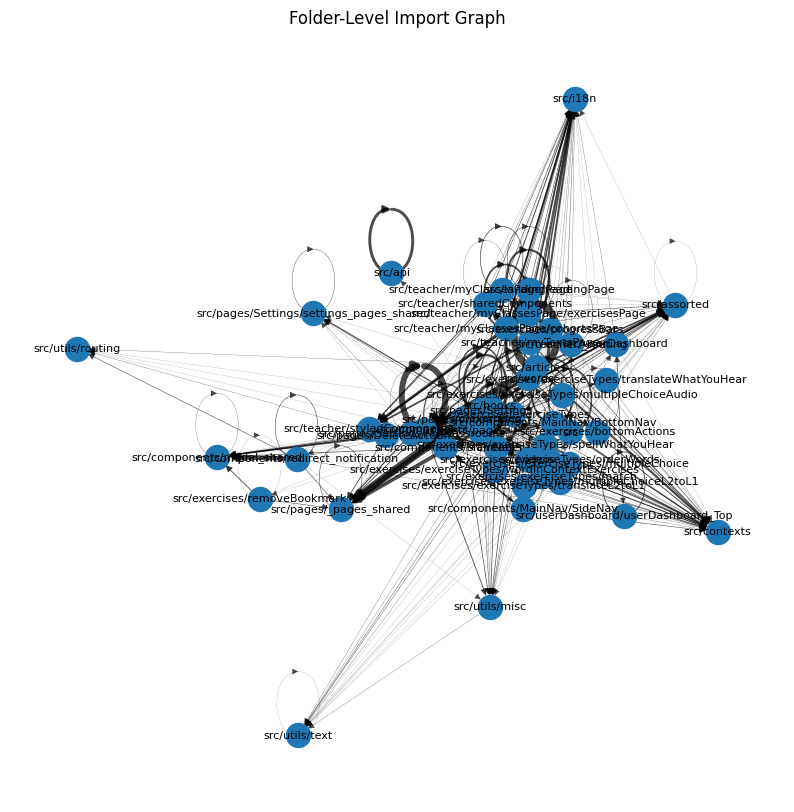

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
def draw_folder_import_graph(root_path, file_exts=['.js'], max_nodes=20):
    """
    Builds and draws a directed graph of folder-level imports.
    Nodes are folders relative to root_path.
    Edge weight = number of import statements from source folder -> target folder.
    Only the top 'max_nodes' folders by total import activity are shown.
    """
    # Aggregate import counts between folders
    folder_edges = {}

    for dirpath, _, files in os.walk(root_path):
        for fname in files:
            if not any(fname.endswith(ext) for ext in file_exts):
                continue
            importer_file = os.path.join(dirpath, fname)
            importer_folder = os.path.relpath(dirpath, root_path) or '.'

            with open(importer_file, 'r', encoding='utf-8', errors='ignore') as f:
                for line in f:
                    line = line.strip()
                    if line.startswith('import ') and ' from ' in line:
                        parts = line.split(' from ')
                        if len(parts) == 2:
                            mod = parts[1].strip().strip(";").strip("'\"")
                            if mod.startswith('.'):
                                target_path = os.path.normpath(os.path.join(dirpath, mod))
                                # try with extensions
                                for ext in file_exts + ['']:
                                    cand = target_path + ext
                                    if os.path.isfile(cand):
                                        target_folder = os.path.relpath(os.path.dirname(cand), root_path) or '.'
                                        key = (importer_folder, target_folder)
                                        folder_edges[key] = folder_edges.get(key, 0) + 1
                                        break

    # Build graph
    G = nx.DiGraph()
    for (src, dst), weight in folder_edges.items():
        G.add_edge(src, dst, weight=weight)

    # Limit to top nodes by total import activity
    if G.number_of_nodes() > max_nodes:
        activity = {n: sum(d['weight'] for _, _, d in G.edges(n, data=True)) +
                       sum(d['weight'] for _, _, d in G.in_edges(n, data=True))
                    for n in G.nodes()}
        top_nodes = sorted(activity, key=activity.get, reverse=True)[:max_nodes]
        G = G.subgraph(top_nodes).copy()

    # Draw
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=300)
    # Draw edges with width proportional to weight
    weights = [d['weight'] for (_, _, d) in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, width=[w * 0.1 for w in weights], alpha=0.7)
    # Labels
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title("Folder-Level Import Graph")
    plt.axis('off')
    plt.show()

# Example usage:
draw_folder_import_graph(ROOT, max_nodes=50)


### Third‑Party Library Usage


In [42]:
def count_third_party_imports(root_path, pkg_json="/package.json"):
    """
    Reads dependencies from package.json, then walks all .js/.sc.js files
    to count how many import statements reference each dependency.
    Returns a DataFrame with columns [dependency, version, import_count].
    """
    # load declared deps
    with open(pkg_json, 'r', encoding='utf-8') as f:
        pkg = json.load(f)
    deps = pkg.get("dependencies", {})

    counts = {dep: 0 for dep in deps}

    # scan files
    for dirpath, _, files in os.walk(root_path):
        for fname in files:
            if not (fname.endswith(".js") or fname.endswith(".sc.js")):
                continue
            full = os.path.join(dirpath, fname)
            with open(full, 'r', encoding='utf-8', errors='ignore') as f:
                for line in f:
                    line = line.strip()
                    if line.startswith("import ") and ' from ' in line:
                        mod = line.split(' from ')[1].strip().strip(";").strip("'\"")
                        pkg_name = mod.split('/')[0]  # e.g. 'lodash/fp'→'lodash'
                        if pkg_name in counts:
                            counts[pkg_name] += 1

    df = pd.DataFrame([
        {'dependency': dep, 'version': deps[dep], 'import_count': counts[dep]}
        for dep in counts
    ])
    return df
usage_df = count_third_party_imports(ROOT, file_path("package.json"))
usage_df.sort_values('import_count', ascending=False).head(10)

,dependency,version,import_count
27,react,^17.0.1,188
42,styled-components,^5.2.1,126
36,react-router-dom,^5.2.0,71
26,qs,^6.10.3,15
38,react-toastify,^9.1.3,12
43,uuid,^9.0.0,7
32,react-icons,^4.2.0,6
24,moment,^2.29.1,3
30,react-datepicker,^4.1.1,2
28,react-click-outside-hook,^1.1.1,2


### PlantUML Dependency graph

In [11]:
import os
import re
from pathlib import Path
from collections import defaultdict

def get_folder_dependency_puml(root_path, max_depth=1, extensions=['.js']):
    """
    Scans files under `root_path`, up to any depth, but groups them by
    their first `max_depth` path components. Parses `import` statements
    to detect cross-folder dependencies, then emits PlantUML source
    for a package‐dependency diagram.

    Parameters:
      - root_path: str, project root
      - max_depth: int, how many path components to use for grouping
      - extensions: list of str, e.g. ['.js', '.sc.js']; defaults to ['.js','.sc.js']

    Returns:
      - A string containing PlantUML code.
    """

    # Step 1: map each file to its folder‐group
    file_to_group = {}
    for dirpath, _, files in os.walk(root_path):
        for fname in files:
            if any(fname.endswith(ext) for ext in extensions):
                full = Path(dirpath) / fname
                rel = full.relative_to(root_path)
                parts = rel.parts[:-1]  # drop filename
                group = "/".join(parts[:max_depth]) or "."  # "." for root
                file_to_group[str(full)] = group

    # Step 2: parse imports and record edges
    imp_re = re.compile(r"""import\s+(?:[^'"]+from\s+)?['"](.+)['"]""")
    edges = set()
    for filepath, src_group in file_to_group.items():
        text = Path(filepath).read_text(encoding="utf-8", errors="ignore")
        for m in imp_re.finditer(text):
            target = m.group(1)
            # only care about relative imports
            if target.startswith("."):
                # resolve to absolute file path
                cand = (Path(filepath).parent / target).resolve()
                # possible extensions
                for ext in extensions:
                    fpath = cand.with_suffix(ext)
                    if fpath.exists():
                        tgt_group = file_to_group.get(str(fpath))
                        if tgt_group and tgt_group != src_group:
                            edges.add((src_group, tgt_group))
                        break

    # Step 3: emit PlantUML
    lines = ["@startuml", "skinparam packageStyle rectangle", ""]
    # define all groups
    groups = set(file_to_group.values())
    for g in sorted(groups):
        lines.append(f'package "{g}" as {g.replace("/", "_")} {{ }}')
    lines.append("")
    # define dependencies
    for src, tgt in sorted(edges):
        src_id = src.replace("/", "_")
        tgt_id = tgt.replace("/", "_")
        lines.append(f"{src_id} --> {tgt_id}")
    lines.append("\n@enduml")

    return "\n".join(lines)


# Example usage:
puml_text = get_folder_dependency_puml(file_path("src"))
print(puml_text)


@startuml
skinparam packageStyle rectangle

package "." as . { }
package "api" as api { }
package "articles" as articles { }
package "assorted" as assorted { }
package "bookmarklet" as bookmarklet { }
package "components" as components { }
package "contexts" as contexts { }
package "exercises" as exercises { }
package "features" as features { }
package "hooks" as hooks { }
package "i18n" as i18n { }
package "landingPage" as landingPage { }
package "pages" as pages { }
package "reader" as reader { }
package "speech" as speech { }
package "teacher" as teacher { }
package "userDashboard" as userDashboard { }
package "utils" as utils { }
package "videos" as videos { }
package "words" as words { }

. --> api
. --> articles
. --> assorted
. --> components
. --> contexts
. --> exercises
. --> hooks
. --> landingPage
. --> pages
. --> reader
. --> speech
. --> teacher
. --> userDashboard
. --> utils
. --> videos
. --> words
api --> exercises
api --> words
articles --> .
articles --> assorted
a

## Conventions

### Naming

In [6]:
import os
import re
from pathlib import Path
import pandas as pd
from IPython.display import display

def check_naming_conventions_df(root_path):
    camel_re  = re.compile(r'^[a-z]+(?:[A-Z][a-z0-9]+)*$')
    pascal_re = re.compile(r'^[A-Z][A-Za-z0-9]*\.js$')
    folder_violations = []
    file_violations = []
    for dirpath, dirnames, filenames in os.walk(root_path):
        rel = os.path.relpath(dirpath, root_path)
        if rel.startswith('node_modules'):
            continue
        for d in dirnames:
            if not camel_re.match(d):
                folder_violations.append({'folder': os.path.join(rel, d)})
        for f in filenames:
            if f.endswith('.js') and not pascal_re.match(f):
                file_violations.append({'file': os.path.join(rel, f)})
    df_folders = pd.DataFrame(folder_violations)
    df_files = pd.DataFrame(file_violations)
    return df_folders, df_files

df_folders, df_files = check_naming_conventions_df(ROOT)
print("=== Folder Naming Violations ===")
display(df_folders)

=== Folder Naming Violations ===


,folder
0,./.git
1,./.vscode
2,src/i18n
3,src/components/TopNav
4,src/components/redirect_notification
5,src/components/modal_shared
6,src/components/MainNav
7,src/components/MainNav/SideNav
8,src/components/MainNav/BottomNav
9,src/pages/Settings


### Styled imports

In [21]:
def check_styled_imports_df(root_path):
    imp_re = re.compile(r'import\s+(.+)\s+from\s+[\'"](.+\.sc\.(?:js|jsx))[\'"]')
    tag_re = re.compile(r'<\s*([A-Za-z0-9_]+)\s*')
    records = []
    for consumer in Path(root_path).rglob('*.js'):
        text = consumer.read_text(errors='ignore')
        for m in imp_re.finditer(text):
            imported, path = m.groups()
            if imported.strip() != '* as s':
                records.append({
                    'file': str(consumer.relative_to(root_path)),
                    'issue': f"Expected `import * as s from '{path}'`, got `import {imported}`"
                })
            tags = set(tag_re.findall(text))
            for tag in tags:
                if tag in imported and not re.search(rf'<\s*s\.{tag}\b', text):
                    records.append({
                        'file': str(consumer.relative_to(root_path)),
                        'issue': f"Styled component `{tag}` should be used as `<s.{tag}>`"
                    })
    return pd.DataFrame(records)

print("=== Styled Import Violations ===")
display(check_styled_imports_df(ROOT))

=== Styled Import Violations ===


,file,issue
0,src/words/WordsForArticle.js,Expected `import * as s from '../components/al...
1,src/words/WordsForArticle.js,Styled component `StyledButton` should be used...
2,src/landingPage/LandingPage.js,Styled component `s` should be used as `<s.s>`
3,src/components/FeedbackModal.js,Expected `import * as s from '../pages/_pages_...
4,src/components/FeedbackModal.js,Styled component `Form` should be used as `<s....
5,src/components/FeedbackModal.js,Expected `import * as s from './modal_shared/B...
6,src/components/FeedbackModal.js,Styled component `ButtonContainer` should be u...
7,src/components/FeedbackModal.js,Styled component `Button` should be used as `<...
8,src/components/FeedbackModal.js,Expected `import * as s from '../pages/_pages_...
9,src/components/FeedbackModal.js,Styled component `Button` should be used as `<...


### Inline Style

In [7]:
def check_style_separation_df(root_path):
    styled_re = re.compile(r'styled\.[a-zA-Z]')
    records = []
    for js in Path(root_path).rglob('*.js'):
        text = js.read_text(errors='ignore')
        if styled_re.search(text):
            records.append({
                'file': str(js.relative_to(root_path)),
                'issue': "contains inline `styled.` calls—styles should be in .sc.js"
            })
    return pd.DataFrame(records)

print("=== Inline Style Violations ===")
display(check_style_separation_df(ROOT))

=== Inline Style Violations ===


,file,issue
0,src/MainNavWithComponent.sc.js,contains inline `styled.` calls—styles should ...
1,src/words/Word.sc.js,contains inline `styled.` calls—styles should ...
2,src/words/WordsToReview.sc.js,contains inline `styled.` calls—styles should ...
3,src/words/WordsOnDate.sc.js,contains inline `styled.` calls—styles should ...
4,src/landingPage/LandingPage.sc.js,contains inline `styled.` calls—styles should ...
...,...,...
111,src/exercises/exerciseTypes/orderWords/Exercis...,contains inline `styled.` calls—styles should ...
112,src/exercises/progressBars/levelIndicator/Leve...,contains inline `styled.` calls—styles should ...
113,src/videos/VideoPreview.sc.js,contains inline `styled.` calls—styles should ...
114,src/videos/VideoPlayer.sc.js,contains inline `styled.` calls—styles should ...


### Utils usage

In [24]:
def check_utils_usage_df(root_path):
    func_re = re.compile(r'function\s+[a-z][A-Za-z0-9_]*\s*\(')
    records = []
    for js in Path(root_path).rglob('*.js'):
        if '/utils/' in str(js) or js.parent.name == 'utils':
            continue
        text = js.read_text(errors='ignore')
        for m in func_re.finditer(text):
            records.append({
                'file': str(js.relative_to(root_path)),
                'line': text[:m.start()].count('\n')+1,
                'issue': 'move general function to utils/'
            })
    return pd.DataFrame(records)

print("=== Utils Usage Violations ===")
display(check_utils_usage_df(ROOT))

=== Utils Usage Violations ===


,file,line,issue
0,src/App.js,128,move general function to utils/
1,src/App.js,137,move general function to utils/
2,src/words/WordsForArticle.js,16,move general function to utils/
3,src/words/WordsForArticle.js,49,move general function to utils/
4,src/words/WordsForArticle.js,55,move general function to utils/
...,...,...,...
337,src/bookmarklet/bookmarklet.js,6,move general function to utils/
338,public/service-worker.js,35,move general function to utils/
339,public/service-worker.js,64,move general function to utils/
340,public/service-worker.js,121,move general function to utils/


### Notify pattern

In [8]:
def check_notify_pattern_df(root_path):
    child_use_re = re.compile(r'<[A-Z][A-Za-z0-9_]*\s+[^>]*notify[A-Z][a-zA-Z0-9_]*=')
    records = []
    for js in Path(root_path).rglob('*.js'):
        text = js.read_text(errors='ignore')
        for tag in child_use_re.finditer(text):
            prop = re.search(r'notify([A-Z][a-zA-Z0-9_]*)=', tag.group(0)).group(1)
            if not re.search(fr'onNotify{prop}\s*\(', text):
                records.append({
                    'file': str(js.relative_to(root_path)),
                    'issue': f'uses notify{prop}=… but no onNotify{prop} handler'
                })
    return pd.DataFrame(records)

print("=== Notify Pattern Violations ===")
display(check_notify_pattern_df(ROOT))

=== Notify Pattern Violations ===


,file,issue
0,src/words/WordsForArticle.js,uses notifyWordChanged=… but no onNotifyWordCh...
1,src/words/Starred.js,uses notifyUnstar=… but no onNotifyUnstar handler
2,src/words/Word.js,uses notifyWordChange=… but no onNotifyWordCha...
3,src/words/WordsToReview.js,uses notifyDelete=… but no onNotifyDelete handler
4,src/words/WordsToReview.js,uses notifyDelete=… but no onNotifyDelete handler
5,src/words/WordsToReview.js,uses notifyDelete=… but no onNotifyDelete handler
6,src/words/WordsOnDate.js,uses notifyDelete=… but no onNotifyDelete handler
7,src/articles/FindArticles.js,uses notifyVideoClick=… but no onNotifyVideoCl...
8,src/articles/FindArticles.js,uses notifyArticleClick=… but no onNotifyArtic...
9,src/pages/ResetPassword.js,uses notifyEmailSent=… but no onNotifyEmailSen...


## Code Smells

### Duplicate code

In [ ]:
import hashlib
from difflib import SequenceMatcher
from collections import defaultdict

def detect_duplicate_code(root_path, exts=None, similarity_threshold=1.0):
    """
    Detects duplicate or near-duplicate files in a directory tree.

    Parameters:
    - root_path (str): directory to search
    - exts (list of str): file extensions to include (e.g. ['.js', '.sc.js']); if None, include all files
    - similarity_threshold (float): between 0 and 1
        - 1.0 => exact duplicates (by MD5 hash)
        - <1.0 => use SequenceMatcher on file content to find pairs with ratio >= threshold

    Returns:
    - If threshold == 1.0: dict mapping hash -> list of file paths (only hashes with >1 file)
    - If threshold < 1.0: list of tuples (file1, file2, similarity_ratio) for similar pairs
    """
    # Gather files
    files = []
    for dirpath, _, filenames in os.walk(root_path):
        for fname in filenames:
            if exts is None or any(fname.endswith(ext) for ext in exts):
                files.append(os.path.join(dirpath, fname))

    if similarity_threshold == 1.0:
        # Exact duplicates via hash
        hash_map = defaultdict(list)
        for fp in files:
            try:
                with open(fp, 'rb') as f:
                    data = f.read()
                h = hashlib.md5(data).hexdigest()
                hash_map[h].append(fp)
            except Exception:
                continue
        # Filter only hashes with more than one file
        return {h: paths for h, paths in hash_map.items() if len(paths) > 1}
    else:
        # Near duplicates via SequenceMatcher
        similar_pairs = []
        for i in range(len(files)):
            for j in range(i+1, len(files)):
                f1, f2 = files[i], files[j]
                try:
                    with open(f1, 'r', encoding='utf-8', errors='ignore') as a, \
                         open(f2, 'r', encoding='utf-8', errors='ignore') as b:
                        text1, text2 = a.read(), b.read()
                except Exception:
                    continue
                ratio = SequenceMatcher(None, text1, text2).ratio()
                if ratio >= similarity_threshold:
                    similar_pairs.append((f1, f2, round(ratio, 3)))
        return similar_pairs

# Detect exact duplicates - OBS! SLOW
#dups = detect_duplicate_code(ROOT, exts=['.js', '.sc.js'], similarity_threshold=1.0)
#print("Exact duplicate groups:")
#for h, paths in dups.items():
#    print(f"Hash {h}:")
#    for p in paths:
#        print("  ", p)

# Detect near duplicates with threshold 0.9 - OBS! SLOW
#similar = detect_duplicate_code(ROOT, exts=['.js', '.sc.js'], similarity_threshold=0.9)
#print("\nNear-duplicate pairs (ratio >= 0.9):")
#for f1, f2, ratio in similar:
#    print(f"  {ratio}: {f1} <> {f2}")

Exact duplicate groups:

Near-duplicate pairs (ratio >= 0.9):
  0.92: /content/zeeguu-web/src/contexts/SpeechContext.js <> /content/zeeguu-web/src/contexts/APIContext.js
  0.917: /content/zeeguu-web/src/contexts/SpeechContext.js <> /content/zeeguu-web/src/exercises/ExerciseCountContext.js
  0.944: /content/zeeguu-web/src/contexts/RoutingContext.js <> /content/zeeguu-web/src/contexts/APIContext.js
  0.912: /content/zeeguu-web/src/articles/ArticleHistory.js <> /content/zeeguu-web/src/articles/BookmarkedArticles.js
  0.939: /content/zeeguu-web/src/components/MainNav/BottomNav/BottomNavLanguageOption.js <> /content/zeeguu-web/src/components/MainNav/SideNav/SideNavLanguageOption.js
  0.999: /content/zeeguu-web/src/teacher/styledComponents/ReadingInsightAccordion.sc.js <> /content/zeeguu-web/src/teacher/styledComponents/ReadingInsightAccordionItem.sc.js
  0.94: /content/zeeguu-web/src/teacher/styledComponents/TimeSelector.sc.js <> /content/zeeguu-web/src/teacher/styledComponents/NoStudent.sc

### File size

In [9]:
def find_large_files(root_path, min_loc=500, exts=None):
    """
    Walk `root_path` recursively, count lines in each file, and print
    any file whose LOC exceeds `min_loc`.

    Parameters:
    - root_path (str): directory to scan
    - min_loc (int): minimum lines of code threshold
    - exts (list of str or None): list of extensions to include (e.g. ['.js','.sc.js'])
                                   or None to include all files.
    """
    large_files = []
    for dirpath, _, files in os.walk(root_path):
        for fname in files:
            if exts and not any(fname.endswith(ext) for ext in exts):
                continue
            full = os.path.join(dirpath, fname)
            try:
                with open(full, 'r', encoding='utf-8', errors='ignore') as f:
                    loc = sum(1 for _ in f)
            except Exception:
                continue
            if loc > min_loc:
                large_files.append((os.path.relpath(full, root_path), loc))

    # sort descending by LOC
    large_files.sort(key=lambda x: x[1], reverse=True)

    # print results
    print(f"Files with more than {min_loc} lines of code:")
    for path, loc in large_files:
        print(f"  {loc:5d}  {path}")

    return large_files
large_files = find_large_files(ROOT, 500, ['.js'])

Files with more than 500 lines of code:
   1487  src/i18n/definitions.js
   1348  src/exercises/exerciseTypes/orderWords/OrderWords.js
    596  src/articles/TagsOfInterests.sc.js


### Function Size

In [10]:
import re

def find_large_functions(root_path, min_loc=50, exts=None):
    """
    Walk `root_path` recursively, parse JS/SC-JS files (or all if exts=None),
    and report functions larger than `min_loc` lines.

    Parameters:
    - root_path (str): directory to scan
    - min_loc (int): minimum function body lines threshold
    - exts (list of str or None): list of extensions to include (e.g. ['.js', '.sc.js']),
                                   or None for all files.

    Returns:
    - List of tuples: (relative_file_path, function_signature, loc)
    """
    large_funcs = []
    # regex for function declarations and arrows
    func_pattern = re.compile(
        r'^\s*(export\s+)?(?:async\s+)?function\s+([\w$]+)\s*\(|'  # function foo(
        r'^\s*const\s+([\w$]+)\s*=\s*(?:async\s*)?\([^)]*\)\s*=>\s*{',  # const foo = (...) => {
        re.MULTILINE
    )

    for dirpath, _, files in os.walk(root_path):
        for fname in files:
            if exts and not any(fname.endswith(ext) for ext in exts):
                continue
            full = os.path.join(dirpath, fname)
            try:
                with open(full, 'r', encoding='utf-8', errors='ignore') as f:
                    lines = f.readlines()
            except Exception:
                continue

            i = 0
            n = len(lines)
            while i < n:
                line = lines[i]
                match = func_pattern.match(line)
                if match:
                    # determine function name or fallback to signature line
                    name = match.group(2) or match.group(3) or line.strip()
                    # count from this line until matching braces
                    brace_count = line.count('{') - line.count('}')
                    start = i
                    i += 1
                    while i < n and brace_count > 0:
                        brace_count += lines[i].count('{') - lines[i].count('}')
                        i += 1
                    loc = i - start
                    if loc >= min_loc:
                        rel_path = os.path.relpath(full, root_path)
                        large_funcs.append((rel_path, name.strip(), loc))
                else:
                    i += 1

    # sort descending by loc
    large_funcs.sort(key=lambda x: x[2], reverse=True)
    # print results
    print(f"Functions with >= {min_loc} lines:")
    for fpath, fname, loc in large_funcs:
        print(f"  {loc:4d} lines  {fname}  ({fpath})")
    return large_funcs

large_funcs = find_large_functions(ROOT, 50, ['.js'])



Functions with >= 50 lines:
   194 lines  CohortForm  (src/teacher/myClassesPage/cohortsPage/CohortForm.js)
   192 lines  TranslatableText  (src/reader/TranslatableText.js)
   189 lines  App  (src/App.js)
   168 lines  MatchInput  (src/exercises/exerciseTypes/match/MatchInput.js)
   113 lines  ExerciseType  (src/teacher/myClassesPage/exercisesPage/ExerciseType.js)
   105 lines  performSolutionDrop  (src/exercises/exerciseTypes/orderWords/OrderWords.js)
    94 lines  _updateTokensWithBookmarks  (src/reader/InteractiveText.js)
    77 lines  TimeSelector  (src/teacher/sharedComponents/TimeSelector.js)
    73 lines  ShareWithCollegueDialog  (src/teacher/myTextsPage/ShareWithColleagueDialog.js)
    72 lines  StudentTranslations  (src/teacher/myClassesPage/readingPage/StudentTranslations.js)
    68 lines  StudentActivityBar  (src/teacher/myClassesPage/cohortsPage/StudentActivityBar.js)
    64 lines  PractisedWordsList  (src/teacher/myClassesPage/exercisesPage/PractisedWordsList.js)
    63 li

### Parameter counts

In [11]:
def find_functions_with_many_params(root_path, max_params=3, exts=None):
    """
    Scan JS/SC-JS files (or all if exts=None) under root_path,
    and report functions with more than max_params parameters.

    Parameters:
    - root_path (str): directory to scan
    - max_params (int): threshold for number of parameters
    - exts (list of str or None): file extensions to include (e.g. ['.js', '.sc.js'])

    Returns:
    - List of tuples: (relative_file_path, function_name, param_count)
    """
    results = []

    # Patterns for function declarations and arrow functions
    func_decl_pattern = re.compile(r'function\s+([A-Za-z$_]\w*)\s*\(\s*([^)]*?)\s*\)', re.DOTALL)
    arrow_pattern = re.compile(r'const\s+([A-Za-z$_]\w*)\s*=\s*\(\s*([^)]*?)\s*\)\s*=>', re.DOTALL)

    for dirpath, _, files in os.walk(root_path):
        for fname in files:
            if exts and not any(fname.endswith(ext) for ext in exts):
                continue
            full_path = os.path.join(dirpath, fname)
            rel_path = os.path.relpath(full_path, root_path)
            try:
                content = open(full_path, 'r', encoding='utf-8', errors='ignore').read()
            except Exception:
                continue

            # Search function declarations
            for match in func_decl_pattern.finditer(content):
                name, params = match.groups()
                param_list = [p.strip() for p in params.split(',') if p.strip()]
                count = len(param_list)
                if count > max_params:
                    results.append((rel_path, name, count))

            # Search arrow functions
            for match in arrow_pattern.finditer(content):
                name, params = match.groups()
                param_list = [p.strip() for p in params.split(',') if p.strip()]
                count = len(param_list)
                if count > max_params:
                    results.append((rel_path, name, count))

    # Print results
    print(f"Functions with more than {max_params} parameters:")
    for file, func, cnt in results:
        print(f"  {cnt} params - {func}() in {file}")

    return results

funcs = find_functions_with_many_params(ROOT, 4, ['.js'])


Functions with more than 4 parameters:
  10 params - InfoBoxWordsToReview() in src/words/InfoBoxWordsToReview.js
  7 params - Word() in src/words/Word.js
  6 params - WordEditForm() in src/words/WordEditForm.js
  6 params - WordsToReview() in src/words/WordsToReview.js
  7 params - EditBookmarkButton() in src/words/EditBookmarkButton.js
  5 params - updateBookmark() in src/words/EditBookmarkButton.js
  11 params - Selector() in src/components/Selector.js
  5 params - FeedbackModal() in src/components/FeedbackModal.js
  12 params - InputField() in src/components/InputField.js
  5 params - NotificationIcon() in src/components/NotificationIcon.js
  8 params - LanguageSelector() in src/components/LanguageSelector.js
  6 params - DigitalTimer() in src/components/DigitalTimer.js
  6 params - TextField() in src/components/TextField.js
  6 params - ActivityTimer() in src/components/ActivityTimer.js
  8 params - TopTab() in src/components/TopTab.js
  7 params - TopNavOption() in src/components/